# Discrete Time Crystal（離散時間結晶）をQulacsでシミュレーションする

結晶とは、空間的な対称性が自発的にやぶれて構造を持つ現象である。時間軸方向でこのような現象がおきるのが時間結晶である。残念ながら連続的な時間並進対称性を破るような時間結晶は存在しないことが証明されているので、外部から周期的に駆動された離散的な並進対称性の破れである、離散時間結晶の破れについて考える。

## イジングハミルトニアンでの時間

イジングハミルトニアン（横磁場なし）は可換なので量子回路で簡単に実装することができる。

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time 
import random
from qulacs import QuantumState
from qulacs import QuantumCircuit
from qulacs.gate import DenseMatrix
from qulacs.circuit import QuantumCircuitOptimizer
from qulacs import QuantumState
from qulacs.gate import Identity, X,Y,Z #パウリ演算子
from qulacs.gate import H,S,Sdag, sqrtX,sqrtXdag,sqrtY,sqrtYdag #1量子ビット Clifford演算
from qulacs.gate import T,Tdag #1量子ビット 非Clifford演算
from qulacs.gate import RX,RY,RZ #パウリ演算子についての回転演算
from qulacs.gate import CNOT, CZ, SWAP #2量子ビット演算
from qulacs import Observable
import math

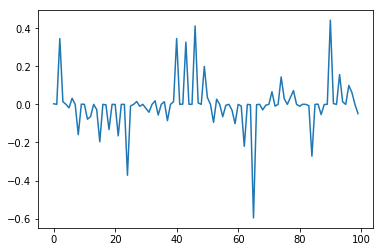

In [2]:
#スピン1/2の数
num_spin=10

#周期
T=1
#シミュレーションする周期数
num_peri =100

#ランダム磁場
hz=[random.random() for i in range(num_spin)]
#hz=[0 for i in range(num_spin)]

IsingDynamics = QuantumCircuit(num_spin)


#一周期分のダイナミクスを定義する
#イジング項の追加
for i in range(num_spin):
    for j in range(i):
        IsingDynamics.add_gate(CNOT(j,i))
        IsingDynamics.add_gate(RZ(i,T))
        IsingDynamics.add_gate(CNOT(j,i))

#ランダム磁場の追加
for i in range(num_spin):
        IsingDynamics.add_gate(RZ(i,T*hz[i]))

#オブザーバブルを定義
X_magnetization = Observable(num_spin)
for i in range(num_spin):
    X_magnetization.add_operator(1.0/num_spin,"X {0}".format(i)) 
    
#各ステップごとにオブザーバーブルを出力してみる
result = []

state = QuantumState(num_spin)
state.set_zero_state()

transversal_H = QuantumCircuit(num_spin)
for i in range(num_spin):
    transversal_H.add_H_gate(i)
    
transversal_H.update_quantum_state(state)

for i in range(num_peri):
    IsingDynamics.update_quantum_state(state)
    result.append(X_magnetization.get_expectation_value(state))
    
plt.plot(result)
plt.show()

離散時間結晶のダイナミクス

In [3]:
#オブザーバブルを定義
Z_magnetization = Observable(num_spin)
for i in range(num_spin):
    Z_magnetization.add_operator(1.0/num_spin,"Z {0}".format(i)) 
    

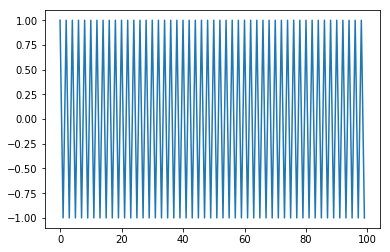

In [4]:
#各ステップごとにオブザーバーブルを出力してみる
result = []


#スピン反転演算子を定義する。
transversal_X =  QuantumCircuit(num_spin)

for i in range(num_spin):
    transversal_X.add_X_gate(i)

    
#初期状態は対称性をやぶった状態にする
state = QuantumState(num_spin)
state.set_zero_state()


# num_peri回繰り返す

for i in range(num_peri):
    result.append(Z_magnetization.get_expectation_value(state))
    IsingDynamics.update_quantum_state(state)
    transversal_X.update_quantum_state(state)
    
plt.plot(result)
plt.show()

当然、2T周期の周期的なダイナミクスが見える。離散時間結晶では、この2T周期性が、スピン反転演算子の摂動に対してロバスト（MBL由来）であることを要求する。


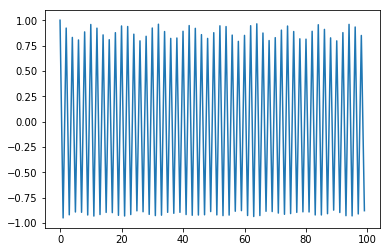

In [5]:
#スピン反転演算子に摂動を加える
transversal_X_rot =  QuantumCircuit(num_spin)


epsilon = 0.1*(np.pi)

for i in range(num_spin):
    transversal_X_rot.add_gate(RX(i,np.pi+epsilon))

result = []
#初期状態は対称性をやぶった状態にする
state = QuantumState(num_spin)
state.set_zero_state()

# num_peri回繰り返す
for i in range(num_peri):
    result.append(Z_magnetization.get_expectation_value(state))
    IsingDynamics.update_quantum_state(state)
    transversal_X_rot.update_quantum_state(state)
    
plt.plot(result)
plt.show()

多少揺らぐものの、周期性が残る。

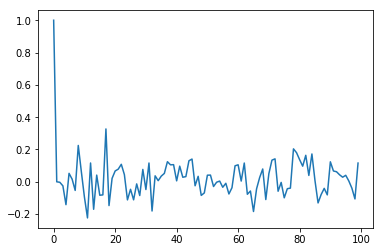

In [6]:
#スピン反転演算子に摂動を加える
transversal_X_rot =  QuantumCircuit(num_spin)


epsilon = 0.5*(np.pi)

for i in range(num_spin):
    transversal_X_rot.add_gate(RX(i,np.pi+epsilon))

    #初期状態は対称性をやぶった状態にする
state = QuantumState(num_spin)
state.set_zero_state()


result = []
# num_peri回繰り返す
for i in range(num_peri):
    result.append(Z_magnetization.get_expectation_value(state))
    IsingDynamics.update_quantum_state(state)
    transversal_X_rot.update_quantum_state(state)
    
plt.plot(result)
plt.show()

ほぼ周期性を失う。

離散結晶ダイナミクスの関数を定義し、出力をフーリヘ変換してみて周期性を定量的にみてみる。

In [7]:
from scipy.fftpack import fft

N = num_peri # data number
dt = 1 # data step [s]

In [8]:
#スピン反転演算子に摂動を加える
def DTC(T,num_peri,epsilon,hz,num_spin):
    
    #オブザーバブルを定義
    Z_magnetization = Observable(num_spin)
    for i in range(num_spin):
        Z_magnetization.add_operator(1.0/num_spin,"Z {0}".format(i))

    IsingDynamics = QuantumCircuit(num_spin)


    #一周期分のダイナミクスを定義する
    #イジング項の追加
    for i in range(num_spin):
        for j in range(i):
            IsingDynamics.add_gate(CNOT(j,i))
            IsingDynamics.add_gate(RZ(i,T))
            IsingDynamics.add_gate(CNOT(j,i))

    #ランダム磁場の追加
    for i in range(num_spin):
            IsingDynamics.add_gate(RZ(i,T*hz[i]))


    #摂動のあるスピンフリップ
    transversal_X_rot =  QuantumCircuit(num_spin)
    for i in range(num_spin):
        transversal_X_rot.add_gate(RX(i,np.pi+epsilon))

    result = []
    #初期状態は対称性をやぶった状態にする
    state = QuantumState(num_spin)
    state.set_zero_state()


    # num_peri回繰り返す
    for i in range(num_peri):
        result.append(Z_magnetization.get_expectation_value(state))
        IsingDynamics.update_quantum_state(state)
        transversal_X_rot.update_quantum_state(state)
    
    return result

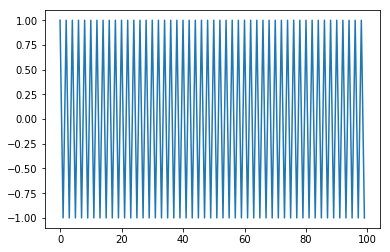

In [21]:
#ランダム磁場
hz=[random.random() for i in range(10)]

plt.plot(DTC(1.0,100,0.0*np.pi,hz,10))
plt.show()

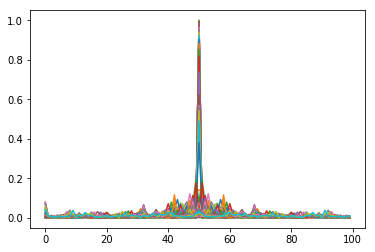

In [22]:
import numpy as np
from scipy.fftpack import fft
import matplotlib.pyplot as plt

#ランダム磁場
hz=[random.random() for i in range(10)]

peak = [[],[]]
for i in range(50):
    tmp_result = np.abs(fft(DTC(1.0,100,0.01*i*np.pi,hz,10))/num_peri)
    peak[0].append(0.01*i*np.pi)
    peak[1].append(tmp_result[50])
    plt.plot(tmp_result)
    
plt.show()


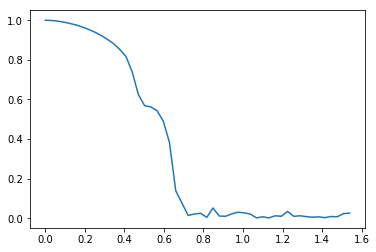

In [23]:
plt.plot(peak[0],peak[1])
plt.show()

ε（スピン反転にたいしる摂動項）が0.7付近で転移がおきている。

量子ビット数を増やす。とりえず20スピン。回路をmergeして最適化する。

In [36]:
from qulacs.circuit import QuantumCircuitOptimizer

#スピン反転演算子に摂動を加える
def DTC_opt(T,num_peri,epsilon,hz,num_spin):
    
    #オブザーバブルを定義
    Z_magnetization = Observable(num_spin)
    for i in range(num_spin):
        Z_magnetization.add_operator(1.0/num_spin,"Z {0}".format(i))

    IsingDynamics = QuantumCircuit(num_spin)


    #一周期分のダイナミクスを定義する
    #イジング項の追加
    for i in range(num_spin):
        for j in range(i):
            IsingDynamics.add_gate(CNOT(j,i))
            IsingDynamics.add_gate(RZ(i,T))
            IsingDynamics.add_gate(CNOT(j,i))

    #ランダム磁場の追加
    for i in range(num_spin):
            IsingDynamics.add_gate(RZ(i,T*hz[i]))


    #摂動のあるスピンフリップ
    for i in range(num_spin):
        IsingDynamics.add_gate(RX(i,np.pi+epsilon))

    #回路をmergeして最適化
    opt = QuantumCircuitOptimizer()
    max_block_size = 5
    opt.optimize(IsingDynamics, max_block_size)

    
    result = []
    #初期状態は対称性をやぶった状態にする
    state = QuantumState(num_spin)
    state.set_zero_state()


    # num_peri回繰り返す
    for i in range(num_peri):
        result.append(Z_magnetization.get_expectation_value(state))
        IsingDynamics.update_quantum_state(state)
    
    return result




20.012783765792847
19.354700565338135
19.09200167655945
18.9776611328125
19.71919870376587
19.93065309524536
19.11346936225891
19.27980899810791
19.31067156791687
19.187626123428345
19.39950656890869
18.963068962097168
18.433912992477417
18.97068190574646
19.41743755340576
19.274330139160156
19.389663219451904
19.14345932006836
19.28021550178528
19.105722665786743
19.496376276016235
19.690370082855225
19.39870572090149
18.63168239593506
19.28783082962036
19.565233945846558
19.666622400283813
19.363776445388794
19.44553017616272
19.695619821548462
19.80412006378174
19.1933650970459
18.684866666793823
18.889172792434692
18.253727674484253
19.33533525466919
19.11111307144165
18.6696617603302
19.24068331718445
19.17023253440857
18.361387968063354
18.68303418159485
18.77773427963257
18.909541368484497
19.08198094367981
18.76283073425293
18.690111875534058
19.134052991867065
19.087866067886353
18.959444046020508


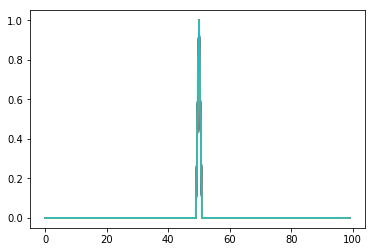

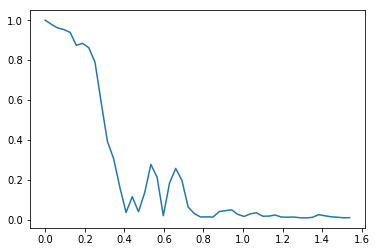

In [25]:
import time
import csv

#ランダム磁場
num_spin =20

hz=[random.random() for i in range(num_spin)]

peak = [[],[]]
result_time =[]
result_freq =[]


for i in range(50):
    start = time.time()
    tmp = DTC_opt(1.0,100,0.01*i*np.pi,hz,num_spin)
    result_time.append(tmp) 
    tmp_fft = np.abs(fft(tmp)/num_peri)
    result_freq.append(tmp_fft)
    elapsed_time = time.time() - start
    peak[0].append(0.01*i*np.pi)
    peak[1].append(tmp_fft[50])

    print(elapsed_time)
    plt.plot(tmp_fft)
plt.show()


plt.plot(peak[0],peak[1])
plt.show()



file1 = open('DTC_time_spin{0}'.format(num_spin)+'.txt',"w")
writer = csv.writer(file1, lineterminator='\n')
writer.writerows(result_time)
file1.close()

file2 = open('DTC_freq_spin{0}'.format(num_spin)+'.txt',"w")
writer = csv.writer(file2, lineterminator='\n')
writer.writerows(result_freq)
file2.close()

file3 = open('DTC_peak_spin{0}'.format(num_spin)+'.txt',"w")
writer = csv.writer(file3, lineterminator='\n')
writer.writerows(peak)
file3.close()

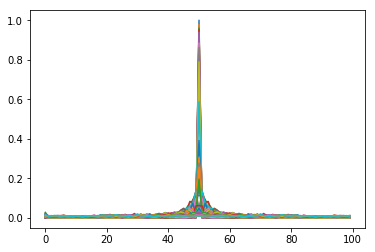

In [33]:
for i in range(50):
    plt.plot(result_freq[i])
plt.show()

gate数がスピン数の２乗で増えて計算時間がかかってしまうので、next nearest neighbor くらいまでのスピンに限定する。

In [45]:

#スピン反転演算子に摂動を加える
def DTC_opt_short(T,num_peri,epsilon,hz,num_spin):
    
    #オブザーバブルを定義
    Z_magnetization = Observable(num_spin)
    for i in range(num_spin):
        Z_magnetization.add_operator(1.0/num_spin,"Z {0}".format(i))

    IsingDynamics = QuantumCircuit(num_spin)


    #一周期分のダイナミクスを定義する
    #イジング項の追加
    for i in range(num_spin):
            
            IsingDynamics.add_gate(CNOT((i+1)%num_spin,i))
            IsingDynamics.add_gate(RZ(i,T))
            IsingDynamics.add_gate(CNOT((i+1)%num_spin,i))

    #ランダム磁場の追加
    for i in range(num_spin):
            IsingDynamics.add_gate(RZ(i,T*hz[i]))


    #摂動のあるスピンフリップ
    for i in range(num_spin):
        IsingDynamics.add_gate(RX(i,np.pi+epsilon))

    #回路をmergeして最適化
    opt = QuantumCircuitOptimizer()
    max_block_size = 5
    opt.optimize(IsingDynamics, max_block_size)

    
    result = []
    #初期状態は対称性をやぶった状態にする
    state = QuantumState(num_spin)
    state.set_zero_state()


    # num_peri回繰り返す
    for i in range(num_peri):
        result.append(Z_magnetization.get_expectation_value(state))
        IsingDynamics.update_quantum_state(state)
    
    return result



3.6609976291656494
2.864422559738159
2.8896536827087402
2.7247579097747803
2.744797706604004
2.9140963554382324
2.9277243614196777
2.7329564094543457
2.936967611312866
2.9612443447113037
2.9316799640655518
2.8895111083984375
2.7537758350372314
2.747462034225464
2.7198429107666016
2.7540581226348877
2.8819222450256348
2.9435105323791504
2.7434661388397217
2.9053382873535156
2.987877607345581
2.755038261413574
2.9178764820098877
2.9103455543518066
2.7695131301879883
2.916830539703369
2.8040406703948975
2.764296531677246
2.7687153816223145
2.964529514312744
2.764080286026001
2.6492340564727783
2.9394073486328125
2.7128188610076904
2.7539238929748535
2.749305248260498
2.7464334964752197
2.7582921981811523
2.7779417037963867
2.8172712326049805
2.8072509765625
2.7671256065368652
2.7493741512298584
2.753706693649292
2.767263174057007
2.76788067817688
2.7462334632873535
2.985255718231201
2.740247964859009
2.690851926803589


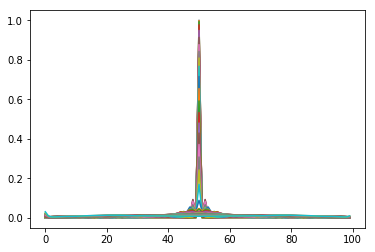

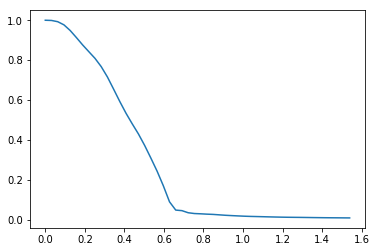

In [40]:

#ランダム磁場
num_spin =20

hz=[random.random() for i in range(num_spin)]

peak = [[],[]]
result_time =[]
result_freq =[]


for i in range(50):
    start = time.time()
    tmp = DTC_opt_short(1.0,100,0.01*i*np.pi,hz,num_spin)
    result_time.append(tmp) 
    tmp_fft = np.abs(fft(tmp)/num_peri)
    result_freq.append(tmp_fft)
    elapsed_time = time.time() - start
    peak[0].append(0.01*i*np.pi)
    peak[1].append(tmp_fft[50])

    print(elapsed_time)
    plt.plot(tmp_fft)
plt.show()


plt.plot(peak[0],peak[1])
plt.show()

file1 = open('DTC_time_short_spin{0}'.format(num_spin)+'.txt',"w")
writer = csv.writer(file1, lineterminator='\n')
writer.writerows(result_time)
file1.close()

file2 = open('DTC_freq_short_spin{0}'.format(num_spin)+'.txt',"w")
writer = csv.writer(file2, lineterminator='\n')
writer.writerows(result_freq)
file2.close()

file3 = open('DTC_peak_short_spin{0}'.format(num_spin)+'.txt',"w")
writer = csv.writer(file3, lineterminator='\n')
writer.writerows(peak)
file3.close()